## Finite Differences

## Forward Euler

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# suppress scientific notation for now
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [21]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
rhomax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0
# Redfield ratio = 0.022 for q

A1_guess = 100.0
Rb1_guess = 2.2
Rd1_guess = 30.0

zmax = 50
delta_z = 0.01

In [22]:
def p(I,q):
    return mumax * (1 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

initial_conditions = np.array([A1_guess,
                              -v*A1_guess/d,
                              Rb1_guess,
                              -v*Rb1_guess/d,
                              Rd1_guess,
                              0.0,
                              I0])

np.set_printoptions(suppress=True)
print(initial_conditions)

[100.     -2.5     2.2    -0.055  30.      0.    300.   ]


In [23]:
def step_forward(y, z_start, delta_z):
    """Forward Euler next step where y is a vector of length 7 of initial guesses."""
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    A1_next = A1 - delta_z*A2
    A2_next = A2 + (delta_z/d)*(v*A2 + p(I,q)*A1 - lbg*A1)
    Rb1_next = Rb1 + delta_z*Rb2
    Rb2_next = Rb2 - (delta_z/d)*(v*Rb2 + rho(q,Rd1)*A1 - lbg*Rb1)
    Rd1_next = Rd1 + delta_z*Rd2
    Rd2_next = Rd2 - (delta_z/d)*(-rho(q,Rd1)*A1 + lbg*Rb1)
    I_next = I - delta_z*(k*A1 + kbg)*I
    
    return np.array([A1_next,
                     A2_next,
                     Rb1_next,
                     Rb2_next,
                     Rd1_next,
                     Rd2_next,
                     I_next])

In [24]:
first_step = step_forward(initial_conditions,0,delta_z)
stepdict = {'z0': initial_conditions, 'z1': first_step}
pd.DataFrame(stepdict, index=['A1','A2','Rb1','Rb2','Rd1','Rd2','I'])

,z0,z1
A1,100.0000,100.0250
A2,-2.5000,-2.4405
Rb1,2.2000,2.1995
Rb2,-0.0550,-0.0614
Rd1,30.0000,30.0000
Rd2,0.0000,0.0064
I,300.0000,298.7100


## Stepping over z

In [25]:
z_steps = np.arange(0.0,zmax,delta_z) 
steps = np.empty([len(initial_conditions),len(z_steps)])
steps[:,0] = initial_conditions

i=0
for z in z_steps[:-1]:
    i=i+1
    steps[:,i] = step_forward(steps[:,i-1], z, delta_z)

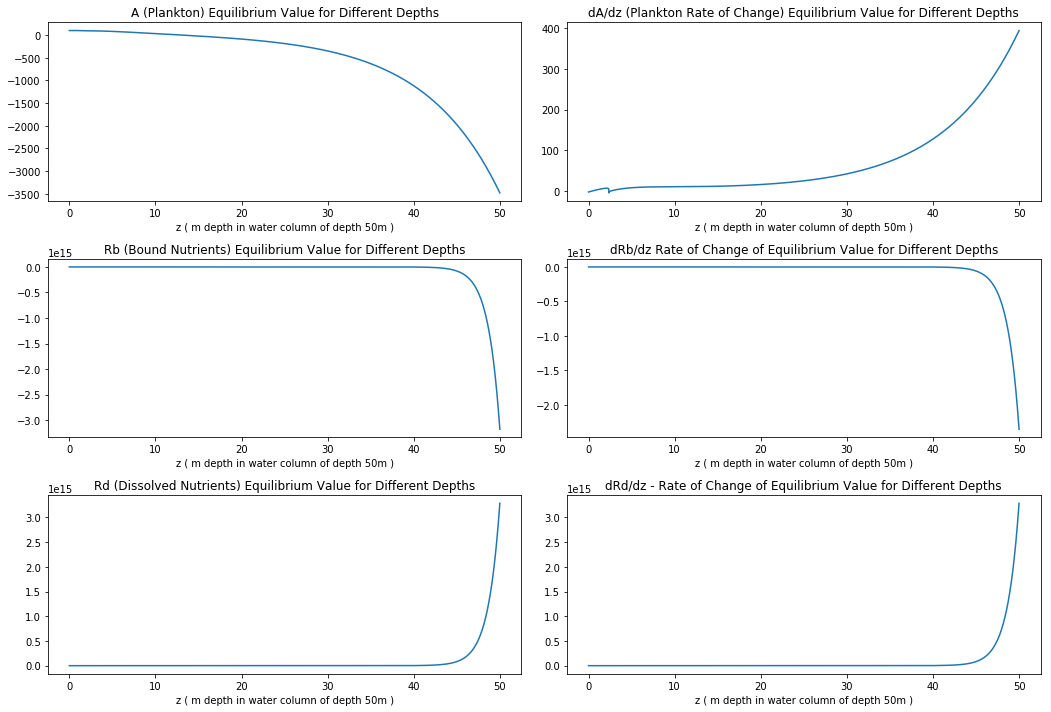

In [26]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(z_steps,steps[0,:])
axs[0,0].set_title('A (Plankton) Equilibrium Value for Different Depths')
axs[0,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[0,1].plot(z_steps,steps[1,:])
axs[0,1].set_title('dA/dz (Plankton Rate of Change) Equilibrium Value for Different Depths')
axs[0,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,0].plot(z_steps,steps[2,:])
axs[1,0].set_title('Rb (Bound Nutrients) Equilibrium Value for Different Depths')
axs[1,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,1].plot(z_steps,steps[3,:])
axs[1,1].set_title('dRb/dz Rate of Change of Equilibrium Value for Different Depths')
axs[1,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,0].plot(z_steps,steps[4,:])
axs[2,0].set_title('Rd (Dissolved Nutrients) Equilibrium Value for Different Depths')
axs[2,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,1].plot(z_steps,steps[4,:])
axs[2,1].set_title('dRd/dz - Rate of Change of Equilibrium Value for Different Depths')
axs[2,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

Text(0.5, 0, 'z ( m depth in water column of depth 50m )')

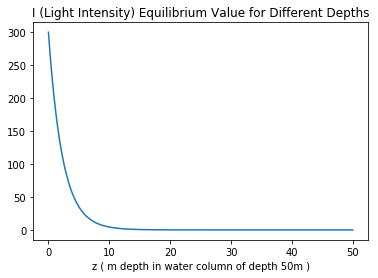

In [13]:
plt.plot(z_steps,steps[6,:])
plt.title('I (Light Intensity) Equilibrium Value for Different Depths')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))


In [15]:
steps_df = pd.DataFrame(steps, index = ['A1','A2','Rb1','Rb2','Rd1','Rd2','I'])
steps_df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
A1,100.0000,100.0250,100.0494,100.0732,100.0964,100.1191,100.1411,100.1625,100.1834,100.2036,...,-3446.4908,-3450.3989,-3454.3114,-3458.2283,-3462.1496,-3466.0754,-3470.0056,-3473.9403,-3477.8794,-3481.8230
A2,-2.5000,-2.4405,-2.3811,-2.3217,-2.2624,-2.2031,-2.1440,-2.0848,-2.0258,-1.9668,...,390.8064,391.2487,391.6914,392.1347,392.5784,393.0226,393.4674,393.9126,394.3584,394.8046
Rb1,2.2000,2.1995,2.1988,2.1982,2.1974,2.1966,2.1957,2.1948,2.1938,2.1927,...,-2975453479445864.5000,-2997461068690798.5000,-3019631434462981.0000,-3041965780719716.5000,-3064465320323237.0000,-3087131275106566.0000,-3109964875939871.0000,-3132967362797304.0000,-3156139984824339.5000,-3179484000405609.0000
Rb2,-0.0550,-0.0614,-0.0679,-0.0743,-0.0808,-0.0872,-0.0937,-0.1001,-0.1066,-0.1131,...,-2200758924493396.7500,-2217036577218249.7500,-2233434625673540.0000,-2249953960352028.0000,-2266595478332898.5000,-2283360083330476.0000,-2300248685743301.0000,-2317262202703568.5000,-2334401558126934.5000,-2351667682762686.0000
Rd1,30.0000,30.0000,30.0001,30.0002,30.0004,30.0006,30.0010,30.0014,30.0018,30.0023,...,3076024733637079.5000,3098776186251875.0000,3121695917291230.0000,3144785171406581.0000,3168045202455281.0000,3191477273568691.0000,3215082657220772.5000,3238862635297190.5000,3262818499164925.5000,3286951549742401.0000
Rd2,0.0000,0.0064,0.0129,0.0194,0.0258,0.0323,0.0388,0.0453,0.0517,0.0582,...,2275145261479545.0000,2291973103935521.5000,2308925411535116.5000,2326003104870023.0000,2343207111340981.5000,2360538365208142.0000,2377997807641799.5000,2395586386773503.0000,2413305057747544.5000,2431154782772828.0000
I,300.0000,298.7100,297.4255,296.1466,294.8731,293.6050,292.3424,291.0852,289.8334,288.5870,...,0.0033,0.0033,0.0034,0.0034,0.0034,0.0034,0.0034,0.0035,0.0035,0.0035


In [19]:
steps_df.iloc[:,2000:2100]

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
A1,-88.0113,-88.1693,-88.3274,-88.4856,-88.6440,-88.8025,-88.9611,-89.1199,-89.2788,-89.4378,...,-102.7613,-102.9315,-103.1019,-103.2723,-103.4430,-103.6137,-103.7847,-103.9557,-104.1269,-104.2983
A2,15.7994,15.8121,15.8248,15.8375,15.8502,15.8630,15.8758,15.8886,15.9014,15.9142,...,17.0190,17.0334,17.0479,17.0624,17.0770,17.0915,17.1061,17.1207,17.1353,17.1499
Rb1,-802429.5226,-808364.4721,-814343.3187,-820366.3870,-826434.0043,-832546.4999,-838704.2058,-844907.4564,-851156.5885,-857451.9416,...,-1557532.7266,-1569052.7035,-1580657.8866,-1592348.9059,-1604126.3965,-1615990.9978,-1627943.3542,-1639984.1148,-1652113.9333,-1664333.4686
Rb2,-593494.9463,-597884.6571,-602306.8359,-606761.7229,-611249.5599,-615770.5906,-620325.0606,-624913.2172,-629535.3095,-634191.5886,...,-1151997.6949,-1160518.3049,-1169101.9366,-1177749.0561,-1186460.1330,-1195235.6403,-1204076.0546,-1212981.8560,-1221953.5281,-1230991.5581
Rd1,829587.9061,835723.4630,841904.4007,848131.0549,854403.7637,860722.8678,867088.7103,873501.6370,879961.9960,886470.1382,...,1610214.2210,1622123.5811,1634121.0274,1646207.2112,1658382.7890,1670648.4219,1683004.7761,1695452.5224,1707992.3370,1720624.9008
Rd2,613555.6843,618093.7689,622665.4189,627270.8826,631910.4100,636584.2531,641292.6657,646035.9036,650814.2242,655627.8872,...,1190936.0131,1199744.6225,1208618.3837,1217557.7787,1226563.2929,1235635.4152,1244774.6385,1253981.4589,1263256.3764,1272599.8948
I,0.0846,0.0843,0.0840,0.0837,0.0834,0.0830,0.0827,0.0824,0.0821,0.0818,...,0.0605,0.0603,0.0601,0.0599,0.0596,0.0594,0.0592,0.0590,0.0588,0.0586


**Note**: changed equations to:

    A1' = -A2
    Rb1' = -Rb2
    Rd1' = -Rd2
    
and this seemed to resolve all the blowing up in forward Euler but I don't understand why it's ok to do. Something to do with 

    A1 goes down when A2 > 0

## Central Difference Method

In [63]:
def step_forward_cdm(y0,y1, z_start, delta_z):
    """Cental Differemnce/Forward Euler next step where y1 and y0 are vectors of length 4 of initial guesses."""
    A0 = y0[0]
    Rb0 = y0[1]
    Rd0 = y0[2]
    I0 = y0[3]
    
    A1 = y1[0] #
    Rb1 = y1[1] #
    Rd1 = y1[2]
    I1 = y1[3]
    
    q = Rb1/A1
    
    A_next = delta_z**2/(v*delta_z - d) * ( (-p(I1,q) + lbg + v/delta_z - 2*d/delta_z**2)*A1 ) + d*A0/(v*delta_z-d)
    
    Rb_next = delta_z**2/(v*delta_z - d) * ( -rho(q,Rd1)*A1 + (v/delta_z + lbg - 2*d/delta_z**2)*Rb1) + d*Rb0/(v*delta_z-d)
    
    Rd_next = delta_z**2/d * (-rho(q,Rd1)*A1 + lbg*Rb1) + 2*Rd1 - Rd0
    
    I_next = - delta_z * (k*A1 + kbg )*I1 + I1 
    
    return np.array([A_next,
                     Rb_next,
                     Rd_next,
                     I_next])

In [64]:
initial_conditions0 = initial_conditions[[0,2,4,6]]
initial_conditions1 = first_step[[0,2,4,6]]

In [65]:
delta_z = 0.00001 # blowing up
z_steps = np.arange(0.0,zmax,delta_z) 

steps_cdm = np.empty([len(initial_conditions0),len(z_steps)])
steps_cdm[:,0] = initial_conditions0
steps_cdm[:,1] = initial_conditions1

In [66]:
i=1
for z in z_steps[:-2]:
    i=i+1
    #print(i)
    steps_cdm[:,i] = step_forward_cdm(steps_cdm[:,i-2],steps_cdm[:,i-1], z, delta_z)
    
# Note: overflow/invalid value encountered in double_scalar encountered at i = 1408

In [67]:
steps_cdm_df = pd.DataFrame(steps_cdm, index=['A','Rb','Rd','I'])
steps_cdm_df

,0,1,2,3,4,5,6,7,8,9,...,4999990,4999991,4999992,4999993,4999994,4999995,4999996,4999997,4999998,4999999
A,100.0000,100.0250,100.0500,100.0750,100.1000,100.1250,100.1500,100.1750,100.2000,100.2250,...,-50565.7000,-50565.6941,-50565.6883,-50565.6824,-50565.6766,-50565.6707,-50565.6648,-50565.6590,-50565.6531,-50565.6473
Rb,2.2000,2.2006,2.2011,2.2017,2.2022,2.2028,2.2033,2.2039,2.2044,2.2050,...,-2217.6468,-2217.6473,-2217.6479,-2217.6484,-2217.6490,-2217.6495,-2217.6500,-2217.6506,-2217.6511,-2217.6517
Rd,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,...,4981.0808,4981.0813,4981.0818,4981.0824,4981.0829,4981.0835,4981.0840,4981.0845,4981.0851,4981.0856
I,300.0000,298.7100,298.7087,298.7074,298.7061,298.7049,298.7036,298.7023,298.7010,298.6997,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [68]:
#nullval = steps_cdm_df.columns[steps_cdm_df.isnull().any()][0]
#print("So the values become null at step {} and Rd is infinity at {}.".format(nullval,nullval-1))

In [69]:
#steps_cdm_df.iloc[:,nullval-1]

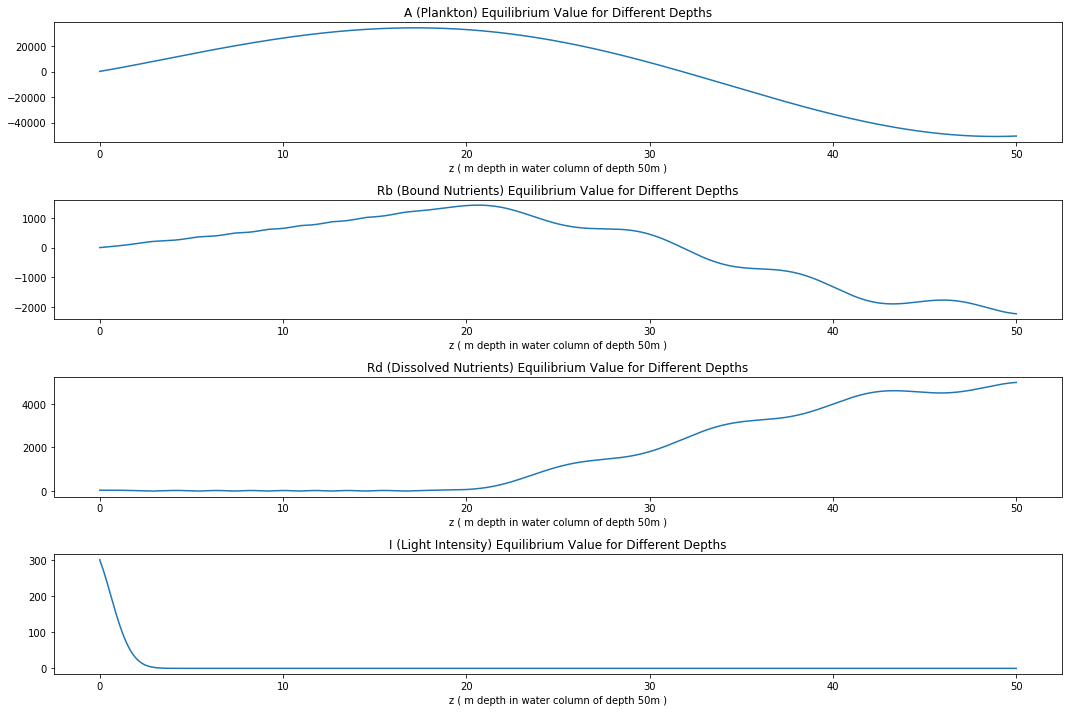

In [70]:
fig, axs = plt.subplots(4, figsize=(15,10))

axs[0].plot(z_steps,steps_cdm[0,:])
axs[0].set_title('A (Plankton) Equilibrium Value for Different Depths')
axs[0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1].plot(z_steps,steps_cdm[1,:])
axs[1].set_title('Rb (Bound Nutrients) Equilibrium Value for Different Depths')
axs[1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2].plot(z_steps,steps_cdm[2,:])
axs[2].set_title('Rd (Dissolved Nutrients) Equilibrium Value for Different Depths')
axs[2].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[3].plot(z_steps,steps_cdm[3,:])
axs[3].set_title('I (Light Intensity) Equilibrium Value for Different Depths')
axs[3].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

In [62]:
(rho(q,Rd1)*A1 - lbg*Rb1)

NameError: name 'q' is not defined